In [1]:
import pandas as pd
import asyncio
import matplotlib.pyplot as plt
import tqdm
from openai import AsyncAzureOpenAI
from sklearn.metrics import root_mean_squared_error

Armamos un system prompt con 20 ejemplos como "few shot" para que el modelo entienda mejor la tarea que debe realizar. 

El script está pensado para que se agarren siempre los primeros N ejemplos de un dataset. 

In [ ]:
API_KEY = "8U02J0d4710ZcPDqs9J6cWj7l1CDWKv8Yg8sWRO4eLwLEtsIOfDSJQQJ99BFACHYHv6XJ3w3AAAAACOGRHrr"
ENDPOINT = "https://fausp-mbmvwtiw-eastus2.cognitiveservices.azure.com/"
DEPLOYMENT = "gpt-4o-mini-faus"
VERSION = "2024-12-01-preview"

# Prompt mejorado
SYSTEM_PROMPT = """
Your task is to analyze the match level between a CV and a Job Description (JD).
You must return a number between 0 and 1 representing how well the CV profile fits what the JD is looking for.
The higher the number, the better the match.
Your response must be **only a single decimal number** per example, without any additional text or explanation (e.g., 0.85).

Here are some examples:

CV,JD,score
"Career Objective: Big data analytics working and database warehouse manager with robust experience in handling all kinds of data. I have also used multiple cloud infrastructure services and am well acquainted with them. Currently in search of role that offers more of development.. Skills: ['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', 'Hdfs', 'YARN', 'Core Java', 'Data Science', 'C++', 'Data Structures', 'DBMS', 'RDBMS', 'Informatica', 'Talend', 'Amazon Redshift', 'Microsoft Azure']. Institution: ['The Amity School of Engineering & Technology (ASET), Noida']. Degree: ['B.Tech']. Results: ['N/A']. Result Type: [None]. Field of Study: ['Electronics']. Companies: ['Coca-COla']. Job Skills: [['Big Data']]. Positions: ['Big Data Analyst']. Responsibilities: [Technical Support, Troubleshooting, Collaboration, Documentation, System Monitoring, Software Deployment, Training & Mentorship, Industry Trends, Field Visits]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: Senior Software Engineer. Education: B.Sc in Computer Science & Engineering from a reputed university.. Experience: At least 1 year. Age: null. JD Responsibilities: [Technical Support, Troubleshooting, Collaboration, Documentation, System Monitoring, Software Deployment, Training & Mentorship, Industry Trends, Field Visits]. Required Skills: null",0.85
"Career Objective: Fresher looking to join as a data analyst and junior data scientist. Experienced in creating meaningful data dashboards and evaluation models.. Skills: ['Data Analysis', 'Data Analytics', 'Business Analysis', 'R', 'SAS', 'PowerBi', 'Tableau', 'Data Visualization', 'Business Analytics', 'Machine Learning']. Institution: ['Delhi University - Hansraj College', 'Delhi University - Hansraj College']. Degree: ['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']. Results: ['N/A', 'N/A']. Result Type: ['N/A', 'N/A']. Field of Study: ['Mathematics', 'Statistics']. Companies: ['BIB Consultancy']. Job Skills: [['Data Analysis', 'Business Analysis', 'Machine Learning']]. Positions: ['Business Analyst']. Responsibilities: [Machine Learning Leadership, Cross-Functional Collaboration, Strategy Development, ML/NLP Infrastructure, Prototype Transformation, ML System Design, Algorithm Research, Application Development, Dataset Selection, ML Testing, Statistical Analysis, R&D in ML/NLP, Text Representation, Data Pipeline Design, Statistical Data Analysis, Model Training, Team Collaboration, Research Reporting, Algorithm Analysis]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: Machine Learning (ML) Engineer. Education: M.Sc in Computer Science & Engineering or in any relevant discipline from a reputed University. Experience: At least 5 year(s). Age: null. JD Responsibilities: [Machine Learning Leadership, Cross-Functional Collaboration, Strategy Development, ML/NLP Infrastructure, Prototype Transformation, ML System Design, Algorithm Research, Application Development, Dataset Selection, ML Testing, Statistical Analysis, R&D in ML/NLP, Text Representation, Data Pipeline Design, Statistical Data Analysis, Model Training, Team Collaboration, Research Reporting, Algorithm Analysis]. Required Skills: null",0.75
"Career Objective: null. Skills: ['Software Development', 'Machine Learning', 'Deep Learning', 'Risk Assessment', 'Requirement Gathering', 'Application Support', 'JavaScript', 'Python', 'Docker', 'HTML', 'Hive', 'CSS', 'C', 'C++']. Institution: ['Birla Institute of Technology (BIT), Ranchi']. Degree: ['B.Tech']. Results: ['N/A']. Result Type: ['N/A']. Field of Study: ['Electronics/Telecommunication']. Companies: ['Axis Bank Limited']. Job Skills: [['Unified Payment Interface', 'Risk Prediction', 'Big Data', 'Spark', 'PySpark']]. Positions: ['Software Developer (Machine Learning Engineer)']. Responsibilities: [Trade Marketing Executive, Brand Visibility, Sales Targets, Field Marketing, Campaigns, Product Distribution, Brand Head, Excel, KPIs Tracking]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: Executive/ Senior Executive- Trade Marketing, Hygiene Products. Education: Master of Business Administration (MBA). Experience: At least 3 years. Age: null. JD Responsibilities: [Trade Marketing Executive, Brand Visibility, Sales Targets, Field Marketing, Campaigns, Product Distribution, Brand Head, Excel, KPIs Tracking]. Required Skills: [Brand Promotion, Campaign Management, Field Supervision, Merchandising, promotional activities, Trade Marketing]",0.416666667
"Career Objective: To obtain a position in a fast-paced business office environment, demanding a strong organizational, technical, and interpersonal position utilizing my skills and attributes.. Skills: ['accounts payables', 'accounts receivables', 'Accounts Payable', 'Accounts Receivable', 'administrative functions', 'trial balance', 'banking', 'budget', 'bi', 'closing', 'Computer Applications', 'Credit', 'clients', 'Customer Service', 'data entry', 'delivery', 'driving', 'email', 'insurance', 'inventory', 'ledger', 'Access', 'Excel', 'Outlook', 'PowerPoint', 'Word', 'mortgage loan', 'Enterprise', 'policies', 'QuickBooks', 'Sales', 'sales reports', 'telecommunications', 'phone', 'workflow', 'written']. Institution: ['Martinez Adult Education, Business Training Center ï¼ City , State']. Degree: ['Computer Applications Specialist Certificate Program']. Results: [None]. Result Type: [None]. Field of Study: ['Computer Applications']. Companies: ['Company Name ï¼ City , State', 'Company Name ï¼ City , State', 'Company Name ï¼ City , State', 'Company Name ï¼ City , State', 'Company Name ï¼ City , State', 'N/A']. Job Skills: [['accounts receivables', 'banking', 'G/L Accounts', 'accounts payables', 'credit cards', 'reconcile', 'commission reports', 'credit checks', 'customer service', 'international travel'], ['data entry', 'accounts receivable', 'cash handling', 'customer communication', 'inventory reports', 'problem-solving'], ['mortgage processing', 'analytical aptitude', 'credit reports', 'customer communication'], ['commercial auto underwriting', 'data entry', 'application review', 'customer communication'], ['personal auto underwriting', 'data entry', 'policy review', 'customer service'], ['training', 'medical record review', 'data entry', 'document design', 'customer service', 'team performance']]. Positions: ['Accountant', 'Accounts Receivable Clerk', 'Mortgage Underwriter', 'Commercial Auto Underwriter', 'Personal Auto Underwriter', 'Claims Examiner']. Responsibilities: [Apparel Sourcing, Quality Garment Sourcing, Reliable Partner, Buyer/Vendor Communication]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: Business Development Executive. Education: Bachelor/Honors. Experience: 1 to 3 years. Age: Age 22 to 30 years. JD Responsibilities: [Apparel Sourcing, Quality Garment Sourcing, Reliable Partner, Buyer/Vendor Communication]. Required Skills: [Fast typing skill, IELTSInternet browsing & online work ability.]",0.7600000000000001
"Career Objective: Professional accountant with an outstanding work ethic and integrity seeking to make a valuable contribution utilizing strong analytical, organizational, communication, and computer skills.. Skills: ['Analytical reasoning', 'Compliance testing knowledge', 'Effective time management', 'Public and private accounting', 'accounting', 'accounting systems', 'accounts payable', 'accounts receivable', 'administrative', 'AR', 'billing', 'closing', 'client', 'clients', 'documentation', 'financial', 'financial reports', 'preparation of financial reports', 'Preparation of financial statements', 'fixed assets', 'managing', 'month-end closing', 'policies', 'maintain records', 'reporting', 'Research', 'sales', 'tax', 'taxes', 'tax returns', 'annual reports', 'year-end']. Institution: ['Kent State University']. Degree: ['Bachelor of Business Administration']. Results: ['3.84']. Result Type: [None]. Field of Study: ['Accounting']. Companies: ['Company Name', 'Company Name', 'Company Name', 'Company Name', 'Company Name']. Job Skills: [['collections', 'accounts receivable', 'financial reports', 'AR aging', 'customer queries', 'sales and use tax audits'], ['financial statements', 'GAAP', 'asset', 'liability', 'capital account', 'accounting controls', 'audits'], ['sales tax', 'tax returns', 'business licenses', 'annual reports', 'tax audits'], ['financial reporting', 'fixed assets', 'sales tax', 'cash projections', 'general ledger accounting'], ['audit procedures', 'substantive tests', 'internal accounting', 'tests of compliance', 'audit programs']]. Positions: ['Staff Accountant', 'Senior Accountant', 'Tax Analyst', 'Staff Accountant II', 'Staff Auditor II']. Responsibilities: [iOS Lifecycle, Requirement Analysis, Native Frameworks, iOS Development, API Integration, Technical Communication, UI Design, Performance Optimization, Feature Collaboration, Bug Fixing, Code Translation, High-Performance Development, Task Management, Cross-Team Collaboration, Code Quality]. Activity Type: ['Professional Organization', 'Honor Society', 'Honor Society', 'Honor Society']. Organizations: ['Ohio Society of CPAs', 'Beta Alpha Psi', 'Golden Key International Honour Society', 'Beta Gamma Sigma']. Roles: [None, None, None, None]. Languages: null. Proficiency: null. Certifications From: ['Ohio Notary Public']. Certification Skills: [None]","Job Position: Senior iOS Engineer. Education: Bachelor of Science (BSc) in Computer Science. Experience: At least 4 years. Age: null. JD Responsibilities: [iOS Lifecycle, Requirement Analysis, Native Frameworks, iOS Development, API Integration, Technical Communication, UI Design, Performance Optimization, Feature Collaboration, Bug Fixing, Code Translation, High-Performance Development, Task Management, Cross-Team Collaboration, Code Quality]. Required Skills: [iOS, iOS App Developer, iOS Application Development, iOS Development, Mobile apps Developer (iOS), Native IOS, Swift (iOS), Swift UI]",0.65
"Career Objective: To secure an IT specialist, desktop support, network administration, database administrator, technical support specialist or related position with a growing organization where my Microsoft certification, technical aptitude, networking, Windows and Mac OS, Apple and Android IOS, web development, application development, Linux, Microsoft applications, managing, testing, client support, help desk, technical support, troubleshooting, and leadership skills can benefit those who I work for as well as myself.. Skills: ['Microsoft Applications', 'Network Security', 'Networking', 'PC hardware and software installation, configuration, and troubleshooting', 'Remote Desktop and Help Desk Management', 'Verbal Communication', 'Technical Support', 'Team Leadership', 'Programming Languages', 'On-call tech support', 'Windows & Mac OS', 'Wiring/Wire Spicing: Cat3, Cat5, Cat5e, Coaxial', 'Management', 'VoIP, TCP/IP, IPSec, ATM, SS7, IPX, DNS, BIND, DHCP, HSRP and LAN/WAN architecture', 'Application Development', 'Voice Over IP Telephone', 'Inventory Management']. Institution: ['Glen Oaks High School', 'Glen Oaks High School']. Degree: ['Bachelor Degree', 'Associate Degree']. Results: [None, None]. Result Type: [None, None]. Field of Study: ['Electronics and Communications Engineering Technology', 'Software Development']. Companies: ['N/A', 'Company Name', 'Company Name']. Job Skills: [['Microsoft Applications', 'Windows Applications', 'Mac OS and IOS', 'Network routers', 'Cisco ASA firewall', 'Juniper Net-screen', 'LANs, WANs', 'Cloud Experience'], ['Microsoft applications', 'Windows and Mac OS', 'Linux', 'Web Development'], ['Customer Support', 'Technical Support', 'Network Administration', 'Inventory Management']]. Positions: ['Engineering Systems Installer', 'IT Technician/QA Tester', 'Installation/Service Technician']. Responsibilities: [Machine Learning Design, Data Analysis, Model Training, AI Integration, Innovation, Cross-Functional Collaboration, Model Deployment, Documentation, Analytical Skills, Communication, Team Collaboration]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: ['Microsoft Certification']. Certification Skills: [None]","Job Position: AI Engineer. Education: Bachelors or Masters degree in Computer Science, Engineering, or a related field.. Experience: null. Age: null. JD Responsibilities: [Machine Learning Design, Data Analysis, Model Training, AI Integration, Innovation, Cross-Functional Collaboration, Model Deployment, Documentation, Analytical Skills, Communication, Team Collaboration]. Required Skills: [Python, R or Java, TensorFlow, PyTorch, Scikit-learn.]",0.85
"Career Objective: null. Skills: ['Machine Learning', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Tableau', 'Time Series Analysis']. Institution: ['DJR College and University']. Degree: ['B.Tech']. Results: ['N/A']. Result Type: ['N/A']. Field of Study: ['IT']. Companies: ['Remiro Amio']. Job Skills: [None]. Positions: ['Intern']. Responsibilities: [iOS Lifecycle, Requirement Analysis, Native Frameworks, iOS Development, API Integration, Technical Communication, UI Design, Performance Optimization, Feature Collaboration, Bug Fixing, Code Translation, High-Performance Development, Task Management, Cross-Team Collaboration, Code Quality]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: Senior iOS Engineer. Education: Bachelor of Science (BSc) in Computer Science. Experience: At least 4 years. Age: null. JD Responsibilities: [iOS Lifecycle, Requirement Analysis, Native Frameworks, iOS Development, API Integration, Technical Communication, UI Design, Performance Optimization, Feature Collaboration, Bug Fixing, Code Translation, High-Performance Development, Task Management, Cross-Team Collaboration, Code Quality]. Required Skills: [iOS, iOS App Developer, iOS Application Development, iOS Development, Mobile apps Developer (iOS), Native IOS, Swift (iOS), Swift UI]",0.65
"Career Objective: null. Skills: ['Maintenance', 'Corrective Maintenance', 'Documentation', 'Industrial Machinery', 'Preventive Maintenance', 'Sensors', 'Biotechnology', 'Electrical Mechanical', 'Estimation', 'Hydraulics', 'Mechanical Technician', 'Pneumatics', 'Project Manager', 'Sop', 'Manufacturing Process', 'Apqp', 'Assembly', 'Circuit Boards', 'Dmm', 'Electrical Test', 'Esd', 'First Article Inspection', 'Inspection', 'Medical Devices', 'Oscilloscope', 'Production Process', 'Schematic', 'Soldering', 'Surface Mount', 'Test Engineer', 'Through-hole', 'Wiring', 'Calibration', 'Control Systems', 'Packaging', 'Process Control', 'Sensor', 'Temperature', 'And Humidity', 'Control System Design', 'Electrical Engineer', 'Engineer', 'Entry Level', 'Ieee', 'Mechanical/electrical Engineer', 'Proactive', 'Self Motivated', 'Testing', 'Training', 'Electrical Engineering', 'Pr', 'Public Relations']. Institution: ['POLYTECHNIC UNIVERSITY OF PUERTO RICO']. Degree: ['Bachelor of Science']. Results: ['2.50']. Result Type: ['GPA']. Field of Study: ['Electrical Engineering']. Companies: ['Company Name', 'Company Name', 'Company Name']. Job Skills: [['Electrical Test', 'Soldering', 'Wiring', 'Troubleshooting'], ['Calibration', 'Troubleshooting', 'Preventive Maintenance', 'Installation'], ['Project Estimation', 'Corrective Maintenance', 'Preventive Maintenance', 'Installation']]. Positions: ['Engineering Technician', 'Instrument Technician', 'Project Manager Assistance']. Responsibilities: [iOS Lifecycle, Requirement Analysis, Native Frameworks, iOS Development, API Integration, Technical Communication, UI Design, Performance Optimization, Feature Collaboration, Bug Fixing, Code Translation, High-Performance Development, Task Management, Cross-Team Collaboration, Code Quality]. Activity Type: null. Organizations: null. Roles: null. Languages: ['Spanish']. Proficiency: ['N/A']. Certifications From: ['AIT']. Certification Skills: [None]","Job Position: Senior iOS Engineer. Education: Bachelor of Science (BSc) in Computer Science. Experience: At least 4 years. Age: null. JD Responsibilities: [iOS Lifecycle, Requirement Analysis, Native Frameworks, iOS Development, API Integration, Technical Communication, UI Design, Performance Optimization, Feature Collaboration, Bug Fixing, Code Translation, High-Performance Development, Task Management, Cross-Team Collaboration, Code Quality]. Required Skills: [iOS, iOS App Developer, iOS Application Development, iOS Development, Mobile apps Developer (iOS), Native IOS, Swift (iOS), Swift UI]",0.65
"Career Objective: Certified Data analyst with a degree in Electronics Engineering, I have hands on experience in analyzing & interpreting data with good numerical accuracy.. Skills: ['Python', 'Machine Learning', 'MySQL', 'Data Mining', 'Deep Learning', 'Data Analysis', 'Computer Vision', 'Flask API', 'Predictive Modeling', 'AWS', 'Scikit-Learn', 'Numpy', 'Statistical Analysis', 'Multivariate Analysis', 'Decision Trees', 'Random Forest', 'Xgboost', 'NLP']. Institution: ['Nagpur University']. Degree: ['B.Tech/B.E.']. Results: ['N/A']. Result Type: ['N/A']. Field of Study: ['Electronics/Telecommunication']. Companies: ['AMZ Loans and Mortgages ERC Analytics']. Job Skills: [['Data Analysis', 'Employee Satisfaction', 'HR Collaboration']]. Positions: ['Associate Analyst']. Responsibilities: [Machinery Maintenance, Troubleshooting, Report Preparation, Log Maintenance]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: ['Google Cloud']. Certification Skills: [None]","Job Position: Mechanical Engineer. Education: Bachelor of Science (BSc) in Mechanical Engineering, Diploma in Mechanical. Experience: 2 to 5 years. Age: Age 25 to 40 years. JD Responsibilities: [Machinery Maintenance, Troubleshooting, Report Preparation, Log Maintenance]. Required Skills: [Maintenance  and Troubleshooting, Mechanical]",0.55
"Career Objective: null. Skills: ['Django', 'Python', 'Relational databases', 'RestAPI', 'Github', 'Jira', 'PostgreSQL', 'Software development', 'Debugging', 'Machine learning', 'Natural language Processing', 'Artificial Intelligence', 'Data Analysis', 'Docker', 'Tornado', 'Software Developer', 'Project Management']. Institution: ['Dr. Virendra Swaroop Institute of Computer Studies, Kanpur', 'Pranveer Singh Institute of Technology, Kanpur']. Degree: ['BCA', 'MCA']. Results: [None, None]. Result Type: [None, None]. Field of Study: ['Computers', 'Computers']. Companies: ['Daffodil Software Pvt Ltd']. Job Skills: [['Developing', 'designing', 'optimizing automation script', 'crons', 'managing database conflicts', 'executing solution']]. Positions: ['Software Developer']. Responsibilities: [Apparel Sourcing, Quality Garment Sourcing, Reliable Partner, Buyer/Vendor Communication]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: Business Development Executive. Education: Bachelor/Honors. Experience: 1 to 3 years. Age: Age 22 to 30 years. JD Responsibilities: [Apparel Sourcing, Quality Garment Sourcing, Reliable Partner, Buyer/Vendor Communication]. Required Skills: [Fast typing skill, IELTSInternet browsing & online work ability.]",0.383333333
"Career Objective: Enthusiastic, knowledgeable professional with experience and proven success in program and project management, online and instructor led design, development and facilitation. Outstanding problem-solving skills, as proven through implementation of accounting software packages, significantly improving billing and reporting processes. Excellent management skills, encouraging career growth of subordinates through additional training and opportunities. Keep up-to-date with industry changes through professional affiliation.. Skills: ['Microsoft Office Suite', 'VideoScribe Software', 'PeopleSoft Finance Applications', 'Accounting', 'billing', 'Change Management', 'contracts', 'Client Relations', 'Database', 'delivery', 'Eclipse', 'Finance', 'financial reporting', 'financial statements', 'Front Office', 'hiring', 'instructor', 'Instructional Design', 'Leadership training', 'logistics', 'managing', 'needs analysis', 'payables', 'PeopleSoft HRMS', 'PeopleSoft', 'personnel', 'Program Management', 'Project Management', 'project plans', 'Teaching', 'training materials', 'training design and development', 'training material', 'training programs', 'upgrade', 'view']. Institution: ['CALIFORNIA STATE UNIVERSITY, HAYWARD', 'UNIVERSITY OF MARYLAND, COLLEGE PARK', 'COLLEGE OF ARTS, SCIENCE, AND TECHNOLOGY']. Degree: ['Master of Science', 'Bachelor of Science', 'Bachelor of Science']. Results: ['4.0', None, None]. Result Type: ['GPA', None, None]. Field of Study: ['Education with an option in Online Teaching and Learning', 'Accounting', 'Business Administration']. Companies: ['Company Name', 'Company Name', 'Company Name']. Job Skills: [['Project Management', 'Training Facilitation', 'Instructional Design', 'Development', 'client relations', 'program management', 'accounting'], ['Instructional Design', 'Training Management', 'Database Management'], ['Online Course Instruction']]. Positions: ['Senior Manager', 'Instructional Designer/Training Manager/Database Manager/Senior Accountant', 'Online Course Instructor']. Responsibilities: [Design Creation, CAD Drawings, Design Optimization, Team Collaboration, Compliance Assurance, Design Reviews, Manufacturing Support, Documentation]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: Mechanical Designer. Education: Bachelor’s degree in Mechanical Engineering from a reputed institute.. Experience: At least 5 years. Age: Age at least 24 years. JD Responsibilities: [Design Creation, CAD Drawings, Design Optimization, Team Collaboration, Compliance Assurance, Design Reviews, Manufacturing Support, Documentation]. Required Skills: [AutoCAD, Solidworks]",0.75
"Career Objective: null. Skills: ['R', 'Python', 'Tableau', 'Power BI', 'SQL', 'SAS', 'Deep Learning', 'Neural Networks', 'Artificial Intelligence']. Institution: ['NARSEE MONJEE INSTITUTE']. Degree: ['BCA']. Results: ['N/A']. Result Type: ['N/A']. Field of Study: ['N/A']. Companies: ['DENA FUNDS']. Job Skills: [['predictive data analysis', 'large scale data handling']]. Positions: ['BUSINESS ANALYST']. Responsibilities: [Administrative Support, Scheduling, Filing & Documentation, Communication, Team Support, Equipment Maintenance, Information Provision, Inventory Management, Team Collaboration, OHS Policy Development, Safety Advice, Risk Assessment, Policy Review, OHS Training, Safety Inspections, Unsafe Act Prevention, Incident Investigation, Report Preparation]. Activity Type: ['N/A']. Organizations: ['N/A']. Roles: ['N/A']. Languages: null. Proficiency: null. Certifications From: ['N/A']. Certification Skills: [None]","Job Position: Asst. Manager/ Manger (Administrative). Education: Bachelor/Honors. Experience: At least 5 years. Age: Age at least 28 years. JD Responsibilities: [Administrative Support, Scheduling, Filing & Documentation, Communication, Team Support, Equipment Maintenance, Information Provision, Inventory Management, Team Collaboration, OHS Policy Development, Safety Advice, Risk Assessment, Policy Review, OHS Training, Safety Inspections, Unsafe Act Prevention, Incident Investigation, Report Preparation]. Required Skills: [•Administration, •Health Safety and Environment, •Safety and Security Management]",0.65
"Career Objective: null. Skills: ['Data Analytics', 'Linear Regression', 'Logistic Regression', 'Business Intelligence', 'Business Analysis', 'GraphQL', 'Python']. Institution: ['Raja Kashwant Singh General College']. Degree: ['B.A']. Results: ['N/A']. Result Type: ['N/A']. Field of Study: ['Economics']. Companies: ['D&D Consultancy', 'Tanisha Quromba Brokerage']. Job Skills: [None, None]. Positions: ['Associate Consultant', 'Junior Analyst Intern']. Responsibilities: [Machine Learning Leadership, Cross-Functional Collaboration, Strategy Development, ML/NLP Infrastructure, Prototype Transformation, ML System Design, Algorithm Research, Application Development, Dataset Selection, ML Testing, Statistical Analysis, R&D in ML/NLP, Text Representation, Data Pipeline Design, Statistical Data Analysis, Model Training, Team Collaboration, Research Reporting, Algorithm Analysis]. Activity Type: ['Award', 'Competition', 'Competition']. Organizations: ['N/A', 'N/A', 'Young Economist Innovation']. Roles: ['Silver Medal For Economics Junior Award', 'Finalist at business solution PAN India', 'Winner and Runner-Up for 2018 and 2019 respectively']. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: Machine Learning (ML) Engineer. Education: M.Sc in Computer Science & Engineering or in any relevant discipline from a reputed University. Experience: At least 5 year(s). Age: null. JD Responsibilities: [Machine Learning Leadership, Cross-Functional Collaboration, Strategy Development, ML/NLP Infrastructure, Prototype Transformation, ML System Design, Algorithm Research, Application Development, Dataset Selection, ML Testing, Statistical Analysis, R&D in ML/NLP, Text Representation, Data Pipeline Design, Statistical Data Analysis, Model Training, Team Collaboration, Research Reporting, Algorithm Analysis]. Required Skills: null",0.65
"Career Objective: Energetic, innovative engineering undergraduate, passionate about Machine Learning, NLP and Deep Learning for solving real-world problems, aiming to work in an organization providing great learning experience and growth opportunities for mutual benefit.. Skills: ['C', 'C++', 'Python', 'JAVA', 'HTML', 'CSS', 'JavaScript', 'Data Structures', 'SQL', 'PyCharm', 'Jupyter Notebook', 'Google Colab', 'Code Blocks', 'MATLAB', 'Turbo C++', 'MS Office', 'Scikit-Learn', 'TensorFlow', 'OpenCV', 'NumPy', 'Pytesseract', 'Keras']. Institution: ['Dayalbagh Educational Institute, Dayalbagh, Agra', ""St. Clare's Senior Secondary School, Agra"", ""St. Clare's Senior Secondary School, Agra""]. Degree: ['B.Tech. (Electrical Engineering Specialization in Computer Science)', 'XII', 'X']. Results: ['9.35 (Till 4 semesters)', '94%', '10']. Result Type: ['CGPA', 'Percentage', 'CGPA']. Field of Study: ['Electrical Engineering Specialized in Computer Science', 'N/A', 'N/A']. Companies: ['Genisup India Pvt. Ltd.', 'VUGS Technologies']. Job Skills: [['NLP', 'Web Scraping', 'bs4', 'LDA Topic Modeling'], ['OCR', 'Pytesseract', 'NER Text Classification']]. Positions: ['Intern', 'Intern']. Responsibilities: [Design Creation, CAD Drawings, Design Optimization, Team Collaboration, Compliance Assurance, Design Reviews, Manufacturing Support, Documentation]. Activity Type: ['Competition', 'Competition', 'Membership']. Organizations: ['The ECE Society, BIT Mesra, Ranchi', 'SGGSCC, University of Delhi', 'National Service Scheme']. Roles: ['Participant', 'Winner', 'Member']. Languages: null. Proficiency: null. Certifications From: ['Udemy', 'Coursera', 'Udemy', 'SoloLearn']. Certification Skills: [['Deep Learning', 'Computer Vision', 'OpenCV', 'SSD', 'GANs'], ['Neural Networks', 'Deep Learning'], ['Machine Learning', 'Python', 'R', 'Data Science'], ['Python']]","Job Position: Mechanical Designer. Education: Bachelor’s degree in Mechanical Engineering from a reputed institute.. Experience: At least 5 years. Age: Age at least 24 years. JD Responsibilities: [Design Creation, CAD Drawings, Design Optimization, Team Collaboration, Compliance Assurance, Design Reviews, Manufacturing Support, Documentation]. Required Skills: [AutoCAD, Solidworks]",0.316666667
"Career Objective: Soon-to-be Computer Science graduate eager to continue exploring the inspiring, innovative field of Android Development. As a seasoned intern, I am looking to join an Android Development team with AT&T as a junior developer.. Skills: ['Java', 'Spring', 'Javascript', 'CSS', 'HTML', 'REST APIs', 'React Native', 'Kotlin', 'PostgreSQL', 'MySQL']. Institution: ['University of Santa Clara']. Degree: ['Bachelor of Science']. Results: ['3.6']. Result Type: ['GPA']. Field of Study: ['Computer Science']. Companies: ['Genesis10', 'Novalsys, Inc']. Job Skills: [['Java', 'Kotlin', 'Android Development', 'Performance Monitoring', 'Quality Assurance', 'Problem Solving', 'Team Collaboration'], ['Android Development', 'Bug Fixing', 'Performance Improvement', 'Cross-Functional Collaboration', 'Data Integrity', 'Feature Development']]. Positions: ['Android Developer Intern', 'Android Developer Intern']. Responsibilities: [Machinery Maintenance, Troubleshooting, Report Preparation, Log Maintenance]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: ['AWS', 'OWASP']. Certification Skills: [None, None]","Job Position: Mechanical Engineer. Education: Bachelor of Science (BSc) in Mechanical Engineering, Diploma in Mechanical. Experience: 2 to 5 years. Age: Age 25 to 40 years. JD Responsibilities: [Machinery Maintenance, Troubleshooting, Report Preparation, Log Maintenance]. Required Skills: [Maintenance  and Troubleshooting, Mechanical]",0.583333333
"Career Objective: null. Skills: ['Machine Learning', 'Method Development', 'Artificial Intelligence', 'Data Modeling', 'Data Visualization', 'Data Validation', 'Deep Learning', 'MySQL', 'MongoDB', 'Python', 'Plotly', 'Seaborn', 'Matplotlib']. Institution: ['CDAC ACTS']. Degree: ['B.Tech']. Results: ['N/A']. Result Type: ['N/A']. Field of Study: ['Electronics and Telecommunication']. Companies: ['BlueM Solutions']. Job Skills: [['Machine Learning', 'Python']]. Positions: ['Associate Software Engineer and Analyst']. Responsibilities: [Database Design & Development, SQL Query Optimization, Data Integrity & Security, BI Solutions Development, ETL Process Implementation, Database Maintenance, Backup & Restore Management, Index Rebuilding & Performance Tuning, SQL Server Clustering & High Availability, SQL Server Replication, High Availability Group Management, Database Monitoring & Troubleshooting]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: ['AWS']. Certification Skills: [None]","Job Position: Database Administrator (DBA). Education: Bachelor of Science (BSc) in Computer Science. Experience: At least 1 year. Age: Age 25 to 40 years. JD Responsibilities: [Database Design & Development, SQL Query Optimization, Data Integrity & Security, BI Solutions Development, ETL Process Implementation, Database Maintenance, Backup & Restore Management, Index Rebuilding & Performance Tuning, SQL Server Clustering & High Availability, SQL Server Replication, High Availability Group Management, Database Monitoring & Troubleshooting]. Required Skills: [ASP.NET MVC Strong understanding of database design, Database Administrator (DBA), Database management, Elasticsearch, MongoDB, MySQL database, NoSQL database, REDIS]",0.85
"Career Objective: null. Skills: ['budget', 'hardware', 'network systems', 'database', 'Dec', 'documentation', 'inspection', 'logistics', 'meetings', 'MS Excel', 'Microsoft Office', 'Outlook', 'PowerPoint', 'network', 'networking', 'Operating Systems', 'Oracle', 'personnel', 'presentations', 'progress', 'quality', 'Maintain documentation', 'routers', 'safety', 'scheduling', 'shipping', 'spreadsheets', 'supervision']. Institution: ['University of Phoenix Texas']. Degree: ['Business Administration']. Results: ['N/A']. Result Type: ['N/A']. Field of Study: ['Business Administration']. Companies: ['Company Name', 'Company Name', 'Company Name', 'Company Name']. Job Skills: [['MS Excel', 'PowerPoint', 'Oracle'], ['networking'], ['documentation', 'shipping', 'production'], ['Microsoft Office', 'database', 'network systems', 'production']]. Positions: ['Engineering Technician', 'Consultant', 'Engineering Technician', 'Manufacturing Lead']. Responsibilities: [Hardware & Network Installation, Troubleshooting & Diagnostics, User Training & Capacity Building, Hardware Replacement, Fault Repair & System Setup, Software License & Account Management, Backup Management, System Updates & Maintenance, Server & Storage Management, Documentation & Technical Specifications, Data Protection & Disaster Recovery, Storage & Database Planning, Power & Disk Backup, Incident Management & Escalation, Service Restoration, User Communication & Verification, Incident Classification & Resolution, Major Incident Escalation, Problem & Error Management, Task Assignment & Execution]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: System Administrator (Operation & Maintenance of Server, Storage & Service Desk System). Education: Bachelor/Honors. Experience: 4 to 5 years. Age: null. JD Responsibilities: [Hardware & Network Installation, Troubleshooting & Diagnostics, User Training & Capacity Building, Hardware Replacement, Fault Repair & System Setup, Software License & Account Management, Backup Management, System Updates & Maintenance, Server & Storage Management, Documentation & Technical Specifications, Data Protection & Disaster Recovery, Storage & Database Planning, Power & Disk Backup, Incident Management & Escalation, Service Restoration, User Communication & Verification, Incident Classification & Resolution, Major Incident Escalation, Problem & Error Management, Task Assignment & Execution]. Required Skills: [Cisco, Linux, Operation & Maintenance of Server]",0.85
"Career Objective: Machine Learning Engineer seeking assignments Deep Learning, Reinforcement Learning, Tensorflow. Keras.. Skills: ['Artificial Intelligence', 'Deep Learning', 'Reinforcement Learning', 'Tensorflow Keras', 'Scikit learn', 'Numpy', 'Pandas', 'Matplotlib']. Institution: ['IIIT D&M Kancheepuram, Chennai']. Degree: ['B.Tech(IT)']. Results: ['N/A']. Result Type: ['N/A']. Field of Study: ['Information Technology']. Companies: ['Larsen & Toubro']. Job Skills: [['OCR', 'Machine Learning']]. Positions: ['Analyst Intern']. Responsibilities: [Trade Marketing Executive, Brand Visibility, Sales Targets, Field Marketing, Campaigns, Product Distribution, Brand Head, Excel, KPIs Tracking]. Activity Type: ['Scholarship']. Organizations: ['KSST']. Roles: ['Scholar']. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: Executive/ Senior Executive- Trade Marketing, Hygiene Products. Education: Master of Business Administration (MBA). Experience: At least 3 years. Age: null. JD Responsibilities: [Trade Marketing Executive, Brand Visibility, Sales Targets, Field Marketing, Campaigns, Product Distribution, Brand Head, Excel, KPIs Tracking]. Required Skills: [Brand Promotion, Campaign Management, Field Supervision, Merchandising, promotional activities, Trade Marketing]",0.626666667
"Career Objective: Soon-to-be Computer Science graduate eager to continue exploring the inspiring, innovative field of Android Development. As a seasoned intern, I am looking to join an Android Development team with AT&T as a junior developer.. Skills: ['Java', 'Spring', 'Javascript', 'CSS', 'HTML', 'REST APIs', 'React Native', 'Kotlin', 'PostgreSQL', 'MySQL']. Institution: ['University of Santa Clara']. Degree: ['Bachelor of Science']. Results: ['3.6']. Result Type: ['GPA']. Field of Study: ['Computer Science']. Companies: ['Genesis10', 'Novalsys, Inc']. Job Skills: [['Java', 'Kotlin', 'Android Development', 'Performance Monitoring', 'Quality Assurance', 'Problem Solving', 'Team Collaboration'], ['Android Development', 'Bug Fixing', 'Performance Improvement', 'Cross-Functional Collaboration', 'Data Integrity', 'Feature Development']]. Positions: ['Android Developer Intern', 'Android Developer Intern']. Responsibilities: [Project Design, Data Analysis, ACCORD/Alliance Knowledge, BNBC Standards, Cost Estimation, Feasibility Studies, Documentation, Compliance, Site Monitoring, Policy Enforcement, Legal Compliance, Data Management, Team Collaboration]. Activity Type: null. Organizations: null. Roles: null. Languages: null. Proficiency: null. Certifications From: ['AWS', 'OWASP']. Certification Skills: [None, None]","Job Position: Project Coordinator (Civil). Education: •Bachelor of Business Administration (BBA) in Human Resource Management. Experience: 5 to 10 years. Age: Age 30 to 40 years. JD Responsibilities: [Project Design, Data Analysis, ACCORD/Alliance Knowledge, BNBC Standards, Cost Estimation, Feasibility Studies, Documentation, Compliance, Site Monitoring, Policy Enforcement, Legal Compliance, Data Management, Team Collaboration]. Required Skills: [Auto CAD 2D 3D, Civil 3D, Civil Construction, Civil Engineering]",0.333333333
"Career Objective: null. Skills: ['Machine learning', 'Data Science', 'Deep Learning', 'Decision Trees', 'Random Forest', 'XGBoost', 'CATBoost', 'Classification', 'Regression', 'Scikit Learn', 'Numpy', 'Pandas', 'OpenCV', 'Python', 'Matplotlib', 'Loss Optimization']. Institution: ['Raja Birsimbal College, Ranchi']. Degree: ['B.Tech']. Results: ['N/A']. Result Type: ['N/A']. Field of Study: ['CSE']. Companies: ['TML Infotech']. Job Skills: [['Machine learning', 'Deep Learning', 'Data Science']]. Positions: ['Junior Machine Learning And Deep Learning Engineer']. Responsibilities: [Hardware & Software Installation, System Monitoring, IT Support, Networking Expertise, Mail Server Administration, Security Management, Troubleshooting & Repair, Operations Support]. Activity Type: ['Specialization']. Organizations: ['DeepLearning.ai']. Roles: ['N/A']. Languages: null. Proficiency: null. Certifications From: null. Certification Skills: null","Job Position: Executive/ Sr. Executive -IT. Education: Bachelor of Science (BSc) in Computer Science & Engineering. Experience: 3 to 5 years. Age: Age at most 40 years. JD Responsibilities: [Hardware & Software Installation, System Monitoring, IT Support, Networking Expertise, Mail Server Administration, Security Management, Troubleshooting & Repair, Operations Support]. Required Skills: null",0.65
"""
ammount_of_shots = 20 # Número de ejemplos para el aprendizaje (CAMBIAR VALOR SI SE CAMBIA LA CANTIDAD DE EJEMPLOS USADOS)

In [ ]:
client = AsyncAzureOpenAI(
    api_version=VERSION,
    azure_endpoint=ENDPOINT,
    api_key=API_KEY
)

In [4]:
def load_data():
    # Cargar los datos desde un archivo CSV
    data = pd.read_csv("../datasets/main_dataset/plain_text_resume_data.csv")
    return data

def get_cv_and_jd(df, row_index):
    # Obtener el CV y la descripción del trabajo de una fila específica
    cv = df.iloc[row_index]['CV']
    jd = df.iloc[row_index]['JD']
    score = df.iloc[row_index]['score']
    return cv, jd, score

def plot_results(y_real, y_pred, cantidad):
    # Gráfico de (y_real vs y_pred) comparado con la recta x = y
    plt.figure(figsize=(10, 6))
    plt.scatter(y_real, y_pred, alpha=0.5, label='Predicciones')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='x = y')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.title(f'Resultados de las Predicciones (Cantidad: {cantidad})')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
async def get_completion(prompt):
    response = await client.chat.completions.create(
        model=DEPLOYMENT,
        messages=[{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": prompt}],
        temperature=0.2,
    )
    return response.choices[0].message.content.strip()


### Procesamos cierta cantidad de ejemplos nuevos (para el modelo)

In [ ]:
ammount_of_examples = 15  # Número de ejemplos a procesar
df = load_data()
results = []

# hacer el for con tqdm
for i in tqdm.tqdm(range(ammount_of_examples)):
    cv, jd, real_score = get_cv_and_jd(df, i + ammount_of_shots)
    prompt = f"CV: {cv}\nJD: {jd}\nScore:"
    score = await get_completion(prompt)
    results.append(score)

100%|██████████| 15/15 [01:07<00:00,  4.53s/it]


In [7]:
print("Resultados obtenidos:")
for i, result in enumerate(results):
    print(f"Ejemplo {i + 1}: {result}")

Resultados obtenidos:
Ejemplo 1: 0.25
Ejemplo 2: 0.45
Ejemplo 3: 0.333333333
Ejemplo 4: 0.85
Ejemplo 5: 0.25
Ejemplo 6: 0.25
Ejemplo 7: 0.65
Ejemplo 8: 0.25
Ejemplo 9: 0.75
Ejemplo 10: 0.75
Ejemplo 11: 0.4
Ejemplo 12: 0.5
Ejemplo 13: 0.366666667
Ejemplo 14: 0.25
Ejemplo 15: 0.55


### Printeamos los resultados y los graficamos

Processed 15 valid scores out of 15 examples.
RMSE: 0.3009


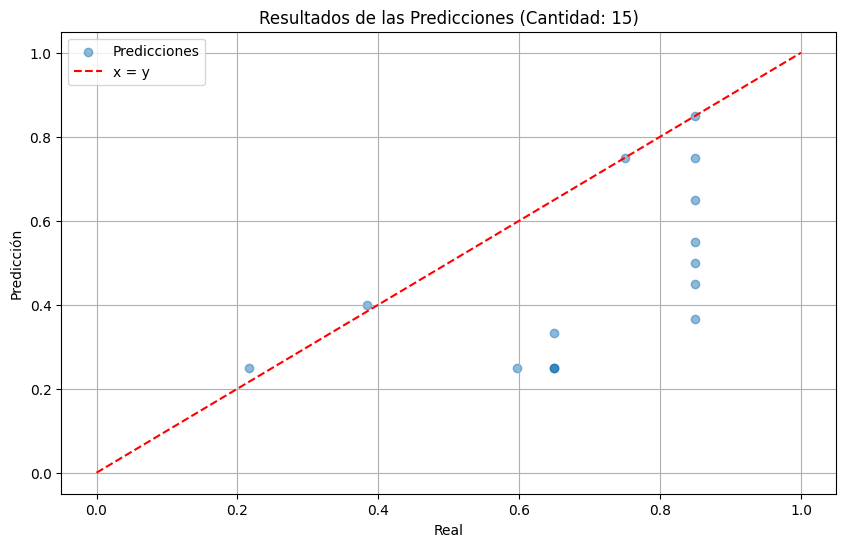

In [10]:

int_results = [float(r) for r in results if r.replace('.', '', 1).isdigit()]
print(f"Processed {len(int_results)} valid scores out of {ammount_of_examples} examples.")

real_results = df['score'].iloc[ammount_of_shots : ammount_of_shots+ammount_of_examples]
real_results = [float(r) for r in real_results if str(r).replace('.', '', 1).isdigit()]

rmse = root_mean_squared_error(real_results, int_results)
print(f"RMSE: {rmse:.4f}")

plot_results(real_results, int_results, ammount_of_examples)